## Potential paper layout - key questions/results

In [1]:
import numpy as np
import scipy as sp
import scipy.stats as ss
import matplotlib.pyplot as plt
%matplotlib inline  
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
import urllib.request
import xarray as xr
import pandas as pd
from glob import glob
import os
import datetime as dt
from collections import OrderedDict
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Polygon
import gsw
from matplotlib import animation, rc
from IPython.display import HTML
import scipy.io
import pycwt as wavelet
from itertools import islice # for slice OrderedDict
from pyspec import helmholtz as helm
from pyspec import spectrum as spec    
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely import geometry

os.chdir("/Users/North/Drive/Work/UniH_Work/DataAnalysis/jlab_files") # need to set working directory to get the next step to work
from Benguela.src.met132_ctd_ladcp_functions import load_combine_ladcp_ctd_data #import load_ctd_data
from Benguela.src.met132_scanfish_sadcp_functions import load_combine_sadcp_scanfish_data #import load_ctd_data
import Benguela.src.met132_calc_functions as cf
import Benguela.src.met132_plotting_functions as fg
import Benguela.src.met132_sea_level_functions as sl
import Denmark_Strait.src.spectra_and_wavelet_functions as sw
import Denmark_Strait.src.ssa_core as ssa
import Benguela.src.calc_Instabilities as ci

# some colors (prettier than default boring colors)
color2 = '#6495ed'
color1 = '#ff6347'
color5 = '#8470ff'
color3 = '#3cb371'
color4 = '#ffd700'
color6 = '#ba55d3'

In [2]:
plt.close(fig='all') # plots stay open with widget until closed; might have to run this often

#matplotlib.get_configdir()
plt.style.use('/Users/North/.matplotlib/manuscript.mplstyle')

T_range = np.array((15,18))
S_range = np.array((35.,35.6))
N_range = np.array((-5,-3))
sigma_range = np.array((24.2,27.2))
sigma_levels = np.arange(sigma_range[0]-0.2,sigma_range[1]+.2,0.05)
U_range = np.array((-0.4,0.4))


#### Loading data

In [3]:
sadcp_nc_dir = '/Users/North/Drive/Work/UniH_Work/DataAnalysis/jlab_files/Benguela/netcdf_files/'
figure_dir = '/Users/North/Drive/Work/UniH_Work/DataAnalysis/jlab_files/Benguela/figures/paper/'

def read_in_scan_sadcp(transect_name):
    # actually just sadcp data, but putting them in same Dict
    scan_sadcp_transects_xkm = xr.open_dataset((sadcp_nc_dir+'scan_sadcp_transects_1km_'+transect_name+'.nc')) 
    scan_sadcp_transects_xkm = scan_sadcp_transects_xkm.set_index(xy=['x_m','lat','lon','time','time_secs'])
    return scan_sadcp_transects_xkm
def read_in_sadcp(transect_name):
    # actually just sadcp data, but putting them in same Dict
    sadcp_transects_xkm = xr.open_dataset((sadcp_nc_dir+'sadcp_transects_1km_'+transect_name+'.nc')) 
    sadcp_transects_xkm = sadcp_transects_xkm.set_index(xy=['x_m','lat','lon','time','time_secs'])
    return sadcp_transects_xkm
def read_in_ctdladcp(transect_name):
    ctd_ladcp_transects_xkm = xr.open_dataset((sadcp_nc_dir+'ctd_ladcp_transects_'+transect_name+'.nc')) 
    ctd_ladcp_transects_xkm = ctd_ladcp_transects_xkm.set_index(xy=['x_m','x_km','lat','lon','time','station'])
    return ctd_ladcp_transects_xkm
def standardize(x):
    # ds.map only works on datasets, so need to us e.g. ds[['ro']]
    return (x - x.mean()) / x.std()
def read_sst_nc(files,dim_concat):
    # load SST map
    paths = sorted(glob(files))
    # load as dataset to get all attributes
    datasets = [xr.open_dataset(p).assign_coords(Date=xr.open_dataset(p).time_coverage_start[:-14])[['sst']] for p in paths]
    combined = xr.concat(datasets,dim_concat)
    combined['Date'] = combined['Date'].astype("datetime64[ns]")
    return combined 

# ====== load Scanfish ADCP data
scan_sadcp_transects_1km_filament = OrderedDict() # Preallocate output dictionary
scan_sadcp_transects_1km_filament['ScanTransect1'] = read_in_scan_sadcp('ScanTransect1')
scan_sadcp_transects_1km_filament['ScanTransect2'] = read_in_scan_sadcp('ScanTransect2')

# ====== KE 
for key in scan_sadcp_transects_1km_filament:
    scan_sadcp_transects_1km_filament[key] = cf.calc_KE(scan_sadcp_transects_1km_filament[key])    
    if 'sigma_0' in scan_sadcp_transects_1km_filament[key]:
        #scan_sadcp_transects_1km_filament[key] = cf.calc_Ri_Balanced(scan_sadcp_transects_1km_filament[key])
        #scan_sadcp_transects_1km_filament[key] = cf.SI_GI_Check(scan_sadcp_transects_1km_filament[key])
        scan_sadcp_transects_1km_filament[key],grid = ci.setup_dataset_grid(scan_sadcp_transects_1km_filament[key])
        scan_sadcp_transects_1km_filament[key] = ci.SI_GI_Check(scan_sadcp_transects_1km_filament[key],grid)
        scan_sadcp_transects_1km_filament[key]['x_km'] = xr.full_like(scan_sadcp_transects_1km_filament[key].x_m,
                                                                     scan_sadcp_transects_1km_filament[key].x_m/1e3)
        scan_sadcp_transects_1km_filament[key]= scan_sadcp_transects_1km_filament[key].set_index(xy=['x_m','x_m_left','x_km','lat','lon','time','time_secs'])

# ====== load SADCP data from CTD transects
scan_sadcp_transects_1km_filament['LADCP_CTD_Transect1'] = read_in_sadcp('LADCP_CTD_Transect1')
scan_sadcp_transects_1km_filament['LADCP_CTD_Transect2'] = read_in_sadcp('LADCP_CTD_Transect2')
scan_sadcp_transects_1km_filament['LADCP_CTD_Transect5'] = read_in_sadcp('LADCP_CTD_Transect5')
scan_sadcp_transects_1km_filament['LADCP_CTD_Transect7'] = read_in_sadcp('LADCP_CTD_Transect7')

# ====== load LADCP and CTD data
ladcp_ctd_transects_filament = OrderedDict()
ladcp_ctd_transects_filament['LADCP_CTD_Transect1'] = read_in_ctdladcp('LADCP_CTD_Transect1')
ladcp_ctd_transects_filament['LADCP_CTD_Transect2'] = read_in_ctdladcp('LADCP_CTD_Transect2')
ladcp_ctd_transects_filament['LADCP_CTD_Transect5'] = read_in_ctdladcp('LADCP_CTD_Transect5')
ladcp_ctd_transects_filament['LADCP_CTD_Transect7'] = read_in_ctdladcp('LADCP_CTD_Transect7')

# ====== load SST map
# sst map as xr.dataset
sst_files = '/Users/North/Drive/Work/UniH_Work/DataAnalysis/Data/MET_132/Remote_Sensing/downloaded_sst_nc_files_on_20.11.2019/A2016*.L3m_DAY_SST.x_sst.nc'
sst_map_ds = read_sst_nc(sst_files,'Date')

# ====== load SSH map
gos_map = xr.open_dataset(sadcp_nc_dir+'sla_gos.nc')
# ====== sadcp for full cruise ship track
sadcp = xr.open_dataset(sadcp_nc_dir+'sadcp_1km.nc')

# ====== load MITgcm ECCO 4320 spectra; domain and transects
mitgcm_ecco_4320_domainSpectra = xr.open_dataset(sadcp_nc_dir+'ke_spectra_from_small_domain_MITgcm_ECCO.nc')

# ======  load drifter data set
nc_dir = '/Users/North/Drive/Work/UniH_Work/DataAnalysis/jlab_files/Benguela/netcdf_files/'
drifter_ds = xr.open_dataset(nc_dir+'drifter_Dataset.nc')
# Ro estimated for drifters
drifter_Ro = xr.open_dataset(sadcp_nc_dir+'drifter_clusters_Ro_Div_Release1.nc')

# ======== setting up velocities for histogram
sadcp['vel'] = (sadcp.u**2 + sadcp.v**2)**0.5
adcp_vel = sadcp['vel'].sel(z=-15,method='nearest')

gos_map['vel'] = (gos_map.ugos**2 + gos_map.vgos**2)**0.5
ssh_vel = gos_map.sel(lon=slice(9,16),lat=slice(-28,-24)).isel(time=slice(0,31)).vel.stack(iter=('lon','lat','time')).reset_index('iter').drop(['lat','lon','time'])



/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of emp

#### Setup functions

In [6]:
def setup_cartopy_ticks(ax,projection=ccrs.PlateCarree(),xtick_diff=1,ytick_diff=-1):
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    # setup ticks
    ax.set_xticks(np.arange(-90,90,xtick_diff), crs=projection)
    ax.set_yticks(np.arange(0,-80,ytick_diff), crs=projection)
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                       dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    return ax

def nice_plot(ds,trans_name,si):
    if 'xy' in ds[trans_name]:
        ds[trans_name] = ds[trans_name].reset_index('xy').swap_dims({'xy': 'x_m'})
    ds[trans_name].sigma_0.plot.contour(x='x_km',ax=axs[si],levels = sigma_levels,colors='0.25',linewidths=1)
    # Mixed layer depth
    ds[trans_name]['MLD'] = (ds[trans_name].sigma_0 - ds[trans_name].sigma_0.sel(z=ds[trans_name].z.max(), method='nearest') )
    #ds[trans_name]['MLD'].reset_index('xy').plot.contour(x='x_km',ax=axs[si],levels=[0.01, 0.1, 0.25], colors='0.05', linewidths=1.5)
    ds[trans_name]['MLD'].plot.contour(x='x_km',ax=axs[si],levels=[0.1], colors='0.05', linewidths=1.5)
    return ds

def add_lats_on_top(ds,axs,dim='x_m'):
    # add second axes with latitudes
    ax2 = axs.twiny() 
    ax2.set_xlim(axs.axis()[0], axs.axis()[1])
    # set tick values to be the matching latitude values
    xtick_vals2 = (ds.interp({dim:axs.get_xticks()}).lat) #.reset_index('xy').swap_dims({'xy': 'x_km'})
    ax2.set_xticklabels(xtick_vals2.values.round(1))
    return ax2

def plot_hist_of_instabilities(ds_in,axs,mld_level=0.1):

    # just interested in Mixed layer and positive EPV (opposite sign of fo)
    ds_in['MLD'] = ds_in.sigma_0 - ds_in.sigma_0.sel(z=ds_in.z.max(),method='nearest') # density nearest to surface
    ds_mld_only = ds_in
    ds_mld_only = ds_mld_only.where(ds_mld_only.MLD<mld_level).where(ds_mld_only.Ertel_Potential_Vorticity>=0.,0)

    #at each km, sum each type of instability; change to individual variables first, with 1s and 0s in order to sum easier
    stable = xr.where(ds_mld_only.reset_index('xy').StableGravMixSymInert==0,1,0)
    gravit = xr.where(ds_mld_only.reset_index('xy').StableGravMixSymInert==1,1,0)
    mix = xr.where(ds_mld_only.reset_index('xy').StableGravMixSymInert==2,1,0)
    symmet = xr.where(ds_mld_only.reset_index('xy').StableGravMixSymInert==3,1,0)
    inertial = xr.where(ds_mld_only.reset_index('xy').StableGravMixSymInert==4,1,0)
    instabil = xr.concat([stable,gravit,mix,symmet,inertial],dim='instability_type')
    instabil['instability_type'] = np.array(('Stable','GI','MI','SI','II'))

    it = 1
    axs.bar(instabil.x_km.values, (instabil.sum('z').isel(instability_type=it)/instabil.sum(('z','instability_type'))).values,
               label=instabil.instability_type.isel(instability_type=it).values,color=plt.cm.tab10(1))
    for it in np.arange(2,instabil.instability_type.size,1):
        axs.bar(instabil.x_km.values, (instabil.sum('z').isel(instability_type=it)/instabil.sum(('z','instability_type'))).values, 
                    bottom=(instabil.sum('z')/instabil.sum(('z','instability_type'))).isel(instability_type=slice(1,it)).
                sum('instability_type').values,
               label=instabil.instability_type.isel(instability_type=it).values,color=plt.cm.tab10(it))
 
    return instabil

#### Determining near-surface velocity from ADCP data, through Kriging

In [4]:
from pykrige.ok import OrdinaryKriging
def get_gridded(var_in,var_name,best_params):
    # perform kriging on input data
    OK = OrdinaryKriging(
        var_in.lon.values,
        var_in.lat.values,
        var_in[var_name].values,
        variogram_model=best_params['variogram_model'],
        verbose=False,
        enable_plotting=False,
        enable_statistics=False,
        coordinates_type="geographic",
        weight=best_params['weight'],
        nlags=best_params['nlags']
    )
    # Execute on grid:
    grid_var, ss1 = OK.execute("grid", grid_lon, grid_lat,n_closest_points=best_params['n_closest_points'])
    # create xarray dataset
    xr_gpr = xr.Dataset({var_name: (['lat','lon'],  grid_var),
                         (var_name+'_std'): (['lat','lon'],ss1)},
                        coords={'lon':(grid_lon),'lat':(grid_lat)})
    return xr_gpr

# isolate ship track of main study area
t_range = ('2016-11-17T00:00:00','2016-12-08T04:00:00')
t_slice = slice(t_range[0],t_range[1])
# focus on near surface data
z_sel, new_grid_size = -17, 100 

# only interested in velocities measured when the ship is going faster than 2.1 m/s; otherwise bad data
vel_ship = (sadcp.uship**2+sadcp.vship**2)**0.5
sadcp_minVel = sadcp.where(vel_ship>2.1).sortby('time').interpolate_na('time')
# data based on optimization in 16.Rossby_Number...
var_in = sadcp_minVel.sel(time=t_slice).sel(z=z_sel,method='nearest').resample(time='0.5H').mean('time')

# Create input space
grid_lon = np.linspace(var_in.lon.min().values, var_in.lon.max().values, new_grid_size)
grid_lat = np.linspace(var_in.lat.min().values, var_in.lat.max().values, new_grid_size)
grid_lon_lat = (np.array([grid_lon, grid_lat])).T

# run kriging and output as Xarray dataset
u_best_params =  {'method': 'ordinary', 'n_closest_points': None, 'nlags': 6, 'variogram_model': 'spherical', 'weight': True}
v_best_params =  u_best_params #{'method': 'ordinary', 'n_closest_points': 20, 'nlags': 8, 'variogram_model': 'spherical', 'weight': False}
sadcp_krig = xr.merge([get_gridded(var_in,'u',u_best_params),get_gridded(var_in,'v',v_best_params)])
sadcp_krig

<xarray.Dataset>
Dimensions:  (lat: 100, lon: 100)
Coordinates:
  * lon      (lon) float64 10.31 10.35 10.39 10.43 ... 14.16 14.2 14.25 14.29
  * lat      (lat) float64 -27.38 -27.36 -27.33 -27.3 ... -24.77 -24.74 -24.71
Data variables:
    u        (lat, lon) float64 -0.0567 -0.04294 -0.02895 ... -0.1299 -0.1281
    u_std    (lat, lon) float64 0.06533 0.06444 0.06338 ... 0.06405 0.06444
    v        (lat, lon) float64 -0.05554 -0.05808 -0.06033 ... 0.004303 0.003329
    v_std    (lat, lon) float64 0.03123 0.03092 0.03057 ... 0.03121 0.03135

#### Calculate Rossby number from u/v velocity grid from kriging

In [5]:
# setting up various Ro
def Ro_from_krig(sadcp_gpr_sel):
    
    # calc Ro from ADCP kriging output
    x_m = np.append(0,np.cumsum(gsw.geostrophy.distance(sadcp_gpr_sel.lon.values, 
                                                        np.ones(sadcp_gpr_sel.lon.shape)*sadcp_gpr_sel.lat[0].values,p=0, axis=0)))
    y_m = np.append(0,np.cumsum(gsw.geostrophy.distance(np.ones(sadcp_gpr_sel.lat.shape)*sadcp_gpr_sel.lat[0].values, 
                                                        sadcp_gpr_sel.lat.values,p=0, axis=0)))
    # need distances for vorticity calc
    sadcp_gpr_sel['x_m'] = xr.full_like(sadcp_gpr_sel.lon,x_m)
    sadcp_gpr_sel['y_m'] = xr.full_like(sadcp_gpr_sel.lat,y_m)
    sadcp_gpr_sel = sadcp_gpr_sel.set_coords(('x_m','y_m'))

    # vertical vort = dv/dx - du/dy
    sadcp_gpr_sel['rel_vort'] = (sadcp_gpr_sel.v.diff('lon')/sadcp_gpr_sel.x_m.diff('lon') - 
                                 sadcp_gpr_sel.u.diff('lat')/sadcp_gpr_sel.y_m.diff('lat'))
    # Coriolis parameter
    earth_rot = 7.2921*10**-5 # rotation rate of the earth rad/s
    lat_mean = sadcp_gpr_sel.lat.mean() # latitude degrees
    sadcp_gpr_sel['fo'] = 2*earth_rot*np.sin(lat_mean*np.pi/180) # coriolis parameter for given latitude s^-1
    sadcp_gpr_sel['Ro'] = sadcp_gpr_sel['rel_vort']/sadcp_gpr_sel.fo
    
    return sadcp_gpr_sel

# Ro from krigged ADCP data
sadcp_krig = Ro_from_krig(sadcp_krig).rename({'lon':'lon_left','lat':'lat_left'})

# combine results for easier plotting; use ADCP data nearest to surface
Ro_gos = xr.concat((gos_map.Ro.sel(time='2016-11-18'),gos_map.Ro.sel(time='2016-11-25'),gos_map.Ro.sel(time='2016-12-01')),
                   dim='time').sortby('lon_left')
Ro_krig = sadcp_krig.Ro.assign_coords({'time':gos_map.time[-2]}) # add random date so they can concat
Ro_all = xr.concat((Ro_gos,Ro_krig.interp_like(Ro_gos)),dim='time')
Ro_all

# *** cleaning up drifter data
def replace_outliers(data, dim='time', perc=0.99):
    # calculate percentile 
    threshold = data.quantile(perc,dim=dim)
    # find outliers and replace them with nan
    mask = xr.where((data <= threshold) & (data >= -threshold),data,np.nan)
    return mask

drifter_Ro_clean = drifter_Ro.set_coords(['lat','lon','lat_res','lon_res'])
drifter_Ro_clean = replace_outliers(drifter_Ro_clean, dim='time', perc=0.99)
drifter_Ro_clean

<xarray.Dataset>
Dimensions:          (calc_method: 2, drifter_cluster: 4, time: 1961)
Coordinates:
    lat              (drifter_cluster, time) float64 -26.72 -26.71 ... -25.5
    lon              (drifter_cluster, time) float64 11.93 11.92 ... 6.018 6.014
  * time             (time) datetime64[ns] 2016-11-21T13:59:59.999993 ... 2017-01-01T09:59:59.999997
  * drifter_cluster  (drifter_cluster) int64 0 1 2 3
  * calc_method      (calc_method) object 'Triangle' 'LeastSquared'
    z                int64 15
    lat_res          (drifter_cluster, time) float64 -26.72 -26.71 ... -25.5
    lon_res          (drifter_cluster, time) float64 11.93 11.92 ... 6.03 6.027
    quantile         float64 0.99
Data variables:
    RossbyNumber     (calc_method, drifter_cluster, time) float64 nan ... nan
    Divergence       (calc_method, drifter_cluster, time) float64 nan ... nan
    temperature      (drifter_cluster, time) float64 16.86 16.86 ... 21.66 21.74

#####    1. Map of study area, cruise track, and drifter tracks


/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


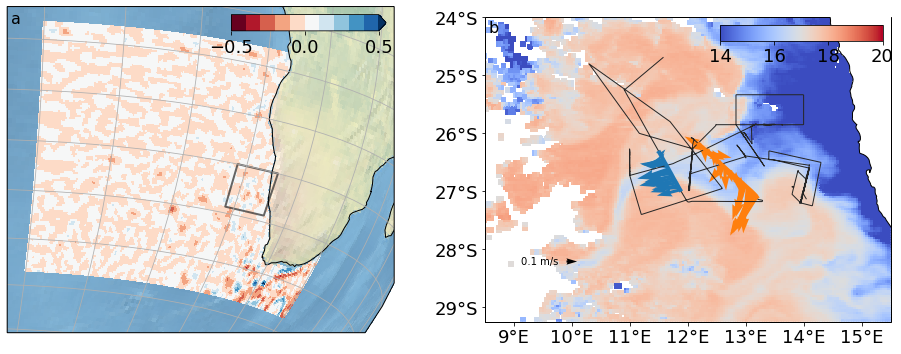

In [7]:
# ======== setup Ro for plotting
lat_lim = np.array((-40,-10))
lon_lim1 = np.array((0,30))
lon_lim2 = np.array((340,360))

# need to do sortby in two steps, otherwise far too slow
Ro_ssh_sel = xr.concat([gos_map.Ro.sel(time=slice('2016-11-15','2016-12-11'),lon_left=slice(lon_lim1[0],lon_lim1[1]),lat_left=slice(lat_lim[0],lat_lim[1])),
                      gos_map.Ro.sel(time=slice('2016-11-15','2016-12-11'),lon_left=slice(lon_lim2[0],lon_lim2[1]),lat_left=slice(lat_lim[0],lat_lim[1]))],
                  dim='lon_left')

Ro_ssh_sel = Ro_ssh_sel.assign_coords({'lon_left' : np.append(np.arange(lon_lim1[0],lon_lim1[1]+0.25,0.25),
                                             np.arange(-360+lon_lim2[0],-360+lon_lim2[1],0.25))}).sortby('lon_left')

# ========
nrows, ncols =  1,2
projection = ccrs.PlateCarree()
fig = plt.figure(figsize=(ncols*8.,nrows*6)) ## setting over-all figure size 

# ======= Plotting Ro and South-Atlantic
si = 0
x_y_lim = [-20,40,-10.,-40]
ax = plt.subplot(1,2,1, projection=ccrs.Orthographic(-30, -15))
p = Ro_ssh_sel.mean('time').plot(transform=projection, vmin=-0.5,vmax=0.5,levels=11,cmap='RdBu', robust=True,
                                           add_colorbar=False,ax=ax)

cbaxes = inset_axes(ax, width="40%", height="5%", loc=1) 
plt.colorbar(p, cax=cbaxes, orientation='horizontal', ticks=np.linspace(-0.5,0.5,3))

# area of subplot
x_y_lim2 = [8.5,15.5,-24.,-29.25]
geom = geometry.box(minx=x_y_lim2[0],maxx=x_y_lim2[1],miny=x_y_lim2[3],maxy=x_y_lim2[2])
ax.add_geometries([geom], crs=projection, alpha=0.75,edgecolor='0.2', facecolor='none', lw=2)

ax.coastlines()
ax.gridlines()
ax.stock_img()
ax.set_title('')
ax.set_rasterized(True) # !! to reduce file size make this image, rest stays vectors

# ======= Plotting SST and ship tracks
ax1 = plt.subplot(1,2,2, projection=projection)
p1 = sst_map_ds.sel(Date=Ro_all.time[0].values,method='nearest').sst.plot(transform=projection, vmin=14,vmax=20,cmap='coolwarm', robust=True,
                                                                 add_colorbar=False,ax=ax1)
cbaxes = inset_axes(ax1, width="40%", height="5%", loc=1) 
plt.colorbar(p1, cax=cbaxes, orientation='horizontal')

# show ship track
(sadcp.sel(z=z_sel,method='nearest').sel(time=t_slice).set_coords(['lon']).lat.plot(x='lon',color='0.15',lw=1,
                                                                    ax=ax1, transform=projection))

# add transects
tran1 = scan_sadcp_transects_1km_filament['ScanTransect1'].reset_index('xy')
tran1.lat.plot(x='lon',lw = 4, color=plt.cm.tab10(0), transform=projection,ax=ax1)
skip, z_ind = 5, -40
sadcp_plt = ax1.quiver(tran1.lon.dropna('xy')[::skip].values, tran1.lat.dropna('xy')[::skip].values, 
                          tran1.u.sel(z=z_ind,method='nearest').dropna('xy')[::skip].values,
                          tran1.v.sel(z=z_ind,method='nearest').dropna('xy')[::skip].values,
                          color=plt.cm.tab10(0), transform=projection)

tran1 = scan_sadcp_transects_1km_filament['ScanTransect2'].reset_index('xy')
tran1.lat.plot(x='lon',lw = 4, color=plt.cm.tab10(1/10), transform=projection,ax=ax1)
sadcp_plt = ax1.quiver(tran1.lon.dropna('xy')[::skip].values, tran1.lat.dropna('xy')[::skip].values, 
                          tran1.u.sel(z=z_ind,method='nearest').dropna('xy')[::skip].values,
                          tran1.v.sel(z=z_ind,method='nearest').dropna('xy')[::skip].values,
                          color=plt.cm.tab10(1/10), transform=projection)

# make quiver key.
qk = plt.quiverkey(sadcp_plt, 0.2, 0.2, 0.1, '0.1 m/s', labelpos='W', color='k')

ax1=setup_cartopy_ticks(ax1)
ax1.set_extent(x_y_lim2, projection)
dataset = cfeature.NaturalEarthFeature(category='physical', name='land', scale='10m')
ax1.add_feature(dataset, zorder=100, edgecolor='k',facecolor='w')#cfeature.COLORS['land'])
#ax1.gridlines(draw_labels=True)
ax1.set_title('')
ax1.set_ylabel('')
ax1.set_xlabel('')
ax1.set_rasterized(True) # !! to reduce file size make this image, rest stays vectors

fg.label_axes(fig,labels=np.array(('a','','b','')),loc=(0.01,0.95),size=16)

figname = figure_dir+'Figure_1_maps_of_transects_Ro_SST.pdf'
fig.savefig(figname, orientation='landscape', bbox_inches='tight')



####    2.1 Time-series of plots showing Filament formation


/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/ipykernel_launcher.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/ipykernel_launcher.py:115: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


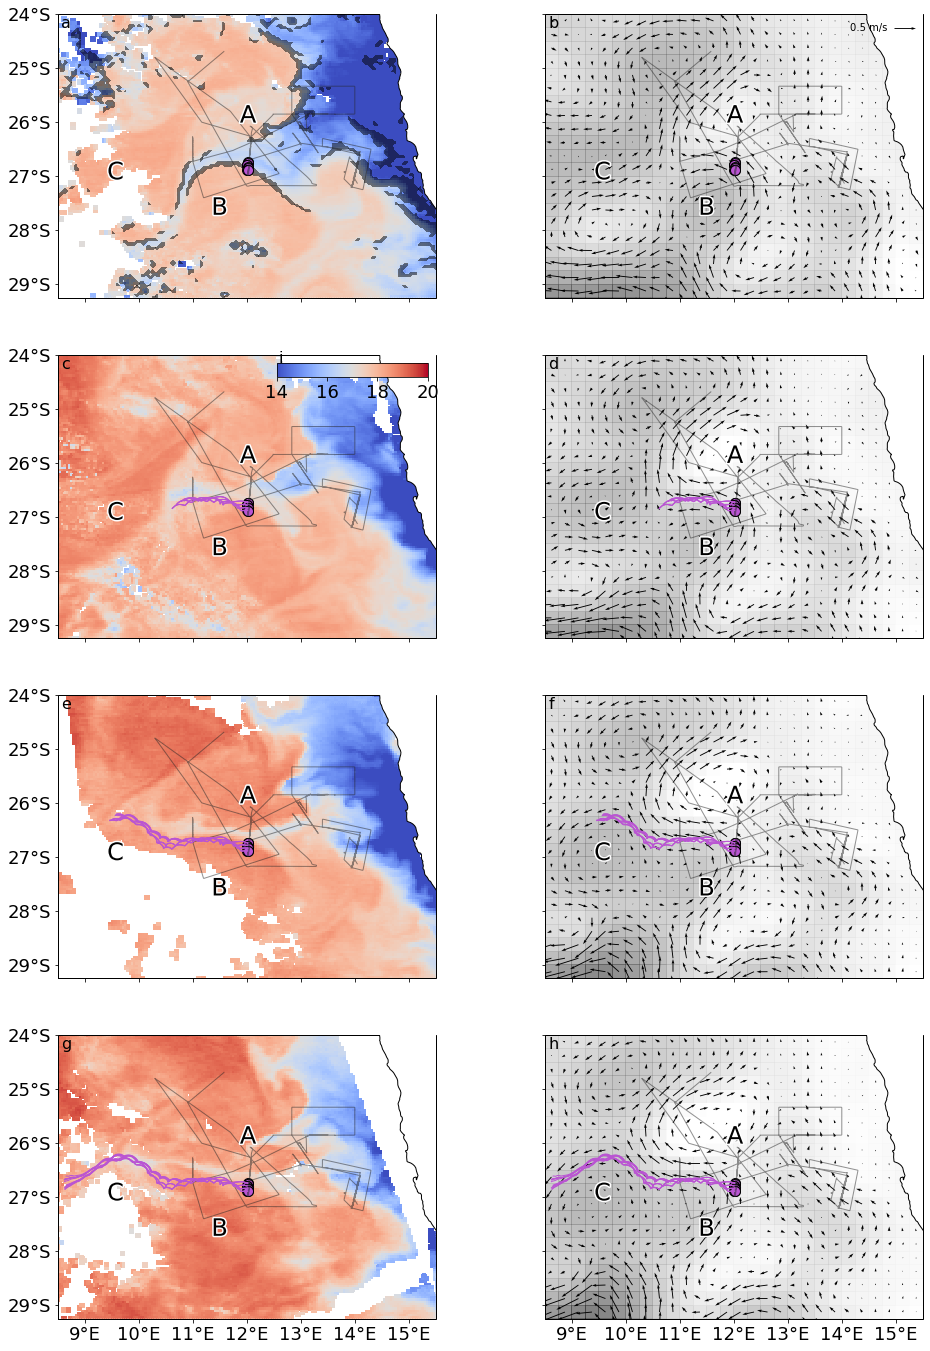

In [9]:

def plot_drifters(drifter_ds,drifter_slice,ndays,ax):
    sel_time = slice(drifter_ds.isel(drifter=drifter_slice).time[0].values,
                     drifter_ds.isel(drifter=drifter_slice).time[0].values  + np.timedelta64(ndays, 'D') )
    drifter_ds.set_coords(['lon']).lat.sel(time=sel_time).isel(drifter=drifter_slice).plot.line(x='lon',hue='drifter',lw = 1, 
                                                                                                alpha=1, color=color6,add_legend=False,
                                                                                                ax = ax)
    for di in np.arange(0,12,1):
        drifter_ds.isel(drifter=di).dropna('time',how='all').isel(time=0).plot.scatter(x='lon',y='lat',lw = 1, color=color6,
                                                                                       edgecolors = 'k',
                                                                                           add_guide=False, ax = ax)
    ax.set_title('')
    ax.set_xlabel('')
    ax.set_ylabel('')

def text_w_outline(x,y,letter,ax):
    import matplotlib.patheffects as PathEffects
    txt = plt.text(x,y,letter,horizontalalignment='right',verticalalignment='bottom',transform=ax.transAxes,fontsize=24)     
    txt.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])

drifter_slice = slice(0,12)
    
nrows, ncols =  4,2
projection = ccrs.PlateCarree()
x_y_lim = [8.5,15.5,-24.,-29.25]
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,figsize = (ncols*8.,nrows*6),subplot_kw=dict(projection=projection))
axs = axs.ravel()

sst_times = np.array(('2016-11-18','2016-11-25','2016-12-01','2016-12-05'))

si = 0
drift_offset = np.array((21,25,31,35))
for stime,do in zip(sst_times,drift_offset):
    p1 = sst_map_ds.sel(Date=stime,method='nearest').sst.plot(transform=projection, vmin=14,vmax=20,cmap='coolwarm', 
                                                          robust=True,add_colorbar=False,ax=axs[si])
    axs[si]=setup_cartopy_ticks(axs[si])
    axs[si].set_extent(x_y_lim, projection)
    dataset = cfeature.NaturalEarthFeature(category='physical', name='land', scale='10m')
    axs[si].add_feature(dataset, zorder=100, edgecolor='k',facecolor='w')#cfeature.COLORS['land'])
    #ax1.gridlines(draw_labels=True)
    axs[si].set_title('')
    axs[si].set_xlabel('')
    if si < 6:
        axs[si].set_xticklabels([])

    if si == 0: # add horizontal gradient
        hgrad = np.gradient(sst_map_ds.sel(Date=stime,method='nearest').sst.values,2,2)
        sst_grad = (xr.full_like(sst_map_ds.sel(Date=stime,method='nearest').sst,
                                 np.sqrt(hgrad[0]**2 + hgrad[1]**2))/
                    np.array(sst_map_ds.sel(Date=stime,method='nearest').spatialResolution[0:4],dtype='float32')) # deg/km
        lon2, lat2 = np.meshgrid(sst_map_ds.sel(Date=stime,method='nearest').lon.values,
                                 sst_map_ds.sel(Date=stime,method='nearest').lat.values)
        axs[si].contourf(lon2, lat2, sst_grad.where(sst_grad>=0.03),
                         alpha=0.5,colors='k',levels=[0.01,0.5],transform= projection)
    if si == 2: 
        cbaxes = inset_axes(axs[si], width="40%", height="5%", loc=1) 
        plt.colorbar(p1, cax=cbaxes, orientation='horizontal', ticks=np.linspace(14,20,4))

    # show ship track
    (sadcp.sel(z=z_sel,method='nearest').sel(time=t_slice).set_coords(['lon']).lat.plot(x='lon',color='0.15',lw=1,alpha=0.5,
                                                                                        ax=axs[si], transform=projection))
    plot_drifters(drifter_ds, drifter_slice, do-21,axs[si]) # drifters[key].time[0].values = 11.21
    text_w_outline(0.525,0.6,'A',axs[si])
    text_w_outline(0.45,0.275,'B',axs[si])   
    text_w_outline(0.175,0.4,'C',axs[si])     
    axs[si].set_rasterized(True) # !! to reduce file size make this image, rest stays vectors

    si = si+2

# ==== SSH map and drifters
si = 1
for sshtime,do in zip(sst_times,drift_offset):
    p1 = gos_map.sel(time=sshtime,lon=slice(8,17),lat=slice(-30,-22)).adt.plot(transform=projection, #vmin=0.25,vmax=0.4,
                                                                               cmap=plt.cm.binary ,alpha=0.5,
                                                                               robust=True,add_colorbar=False,
                                                                               ax=axs[si])
    # add Geostrophic current vectors
    lon2, lat2 = np.meshgrid(gos_map.sel(time=sshtime,lon=slice(8,17),lat=slice(-30,-22)).lon.values,
                             gos_map.sel(time=sshtime,lon=slice(8,17),lat=slice(-30,-22)).lat.values)
    gos_plt = axs[si].quiver(lon2, lat2, gos_map.sel(time=sshtime,lon=slice(8,17),lat=slice(-30,-22)).ugos.values,
                        gos_map.sel(time=sshtime,lon=slice(8,17),lat=slice(-30,-22)).vgos.values , transform=projection)#,scale=700)
    # make quiver key.
    if si ==1: qk = plt.quiverkey(gos_plt, 0.925, 0.95, 0.5, '0.5 m/s', labelpos='W', color='k')
    
    axs[si]=setup_cartopy_ticks(axs[si])
    axs[si].set_extent(x_y_lim, projection)
    dataset = cfeature.NaturalEarthFeature(category='physical', name='land', scale='10m')
    axs[si].add_feature(dataset, zorder=100, edgecolor='k',facecolor='w')#cfeature.COLORS['land'])
    #ax1.gridlines(draw_labels=True)
    axs[si].set_title('')
    axs[si].set_ylabel('')
    axs[si].set_xlabel('')
    axs[si].set_yticklabels([])
    if si < 7:
        axs[si].set_xticklabels([])
    
    # show ship track
    (sadcp.sel(z=z_sel,method='nearest').sel(time=t_slice).set_coords(['lon']).lat.plot(x='lon',color='0.15',lw=1,alpha=0.5,
                                                                                        ax=axs[si], transform=projection))
    plot_drifters(drifter_ds, drifter_slice, do-21,axs[si]) # drifters[key].time[0].values = 11.21
    text_w_outline(0.525,0.6,'A',axs[si])
    text_w_outline(0.45,0.275,'B',axs[si])   
    text_w_outline(0.175,0.4,'C',axs[si])     
    axs[si].set_rasterized(True) # !! to reduce file size make this image, rest stays vectors

    si = si +2

fg.label_axes(fig,loc=(0.01,0.95),size=16)
plt.tight_layout() # squeeze subplots together

figname = figure_dir+'Figure_2_maps_timeseries_filament_SST_SSH.pdf'
fig.savefig(figname, orientation='landscape', bbox_inches='tight')


####    2.2 Characteristics of filament:
##### Sections of Temperature, Salinity and buoyancy frequency crossing the filament

/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/xarray/core/computation.py:604: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/xarray/core/computation.py:604: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/ipykernel_launcher.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


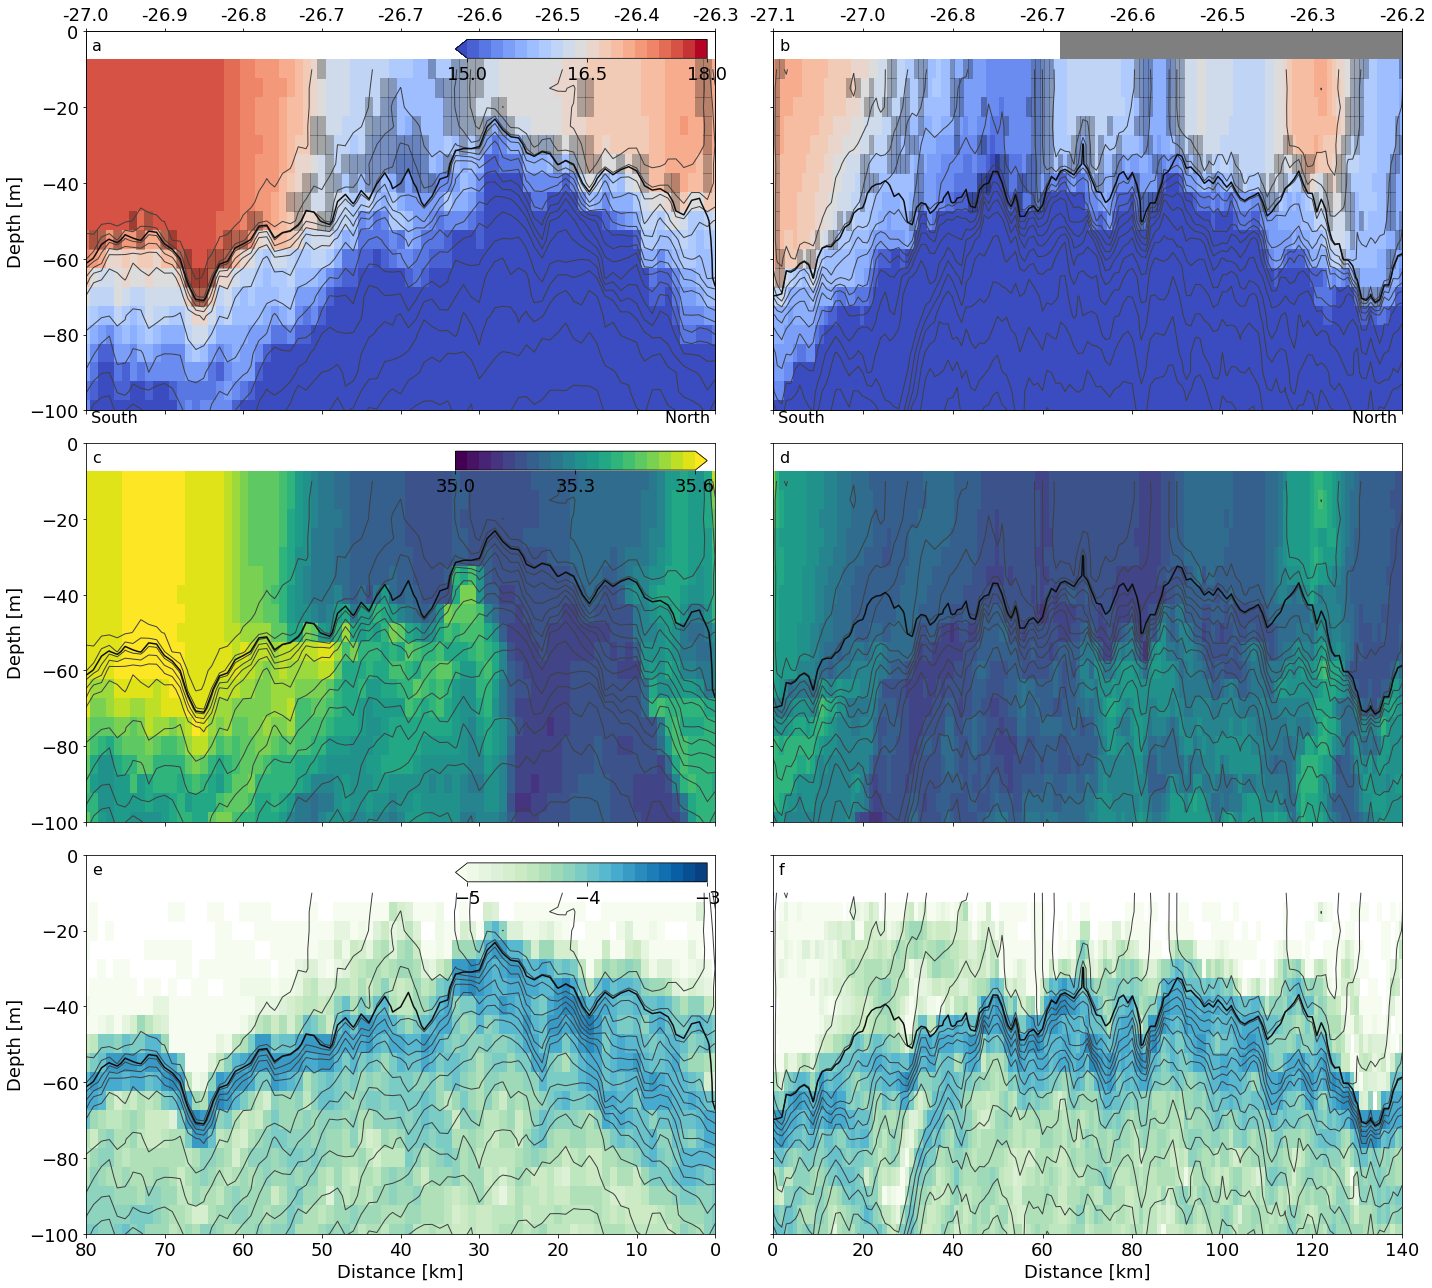

In [9]:
x_lim, y_lim = [80,0], [-100,0]
x_lim2 = [0,140]
mld_level = 0.1
if 'xy' in scan_sadcp_transects_1km_filament['ScanTransect1']:
    scan_sadcp_transects_1km_filament['ScanTransect1'] = (scan_sadcp_transects_1km_filament['ScanTransect1'].reset_index('xy').
                                                          swap_dims({'xy':'x_m'}))
if 'xy' in scan_sadcp_transects_1km_filament['ScanTransect2']:
    scan_sadcp_transects_1km_filament['ScanTransect2'] = (scan_sadcp_transects_1km_filament['ScanTransect2'].reset_index('xy').
                                                          swap_dims({'xy':'x_m'}))

si, nrows, ncols =  0, 3, 2
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,figsize = (ncols*10.,nrows*6))
axs = axs.ravel()
p1 = scan_sadcp_transects_1km_filament['ScanTransect1'].CT.plot(x='x_km',ax=axs[si],vmin=T_range[0],vmax=T_range[1],
                                                                                  levels=21,cmap='coolwarm',add_colorbar=False,
                                                                                 rasterized=True)
scan_sadcp_transects_1km_filament = nice_plot(scan_sadcp_transects_1km_filament,'ScanTransect1', 0)
# add horizontal gradient as shading
h_grad=np.abs(scan_sadcp_transects_1km_filament['ScanTransect1'].db_dx.
        where(scan_sadcp_transects_1km_filament['ScanTransect1'].MLD<mld_level))
h_grad.where(h_grad>1e-7).plot(x='x_km',ax=axs[si],alpha=0.25,colors='k',levels=[1e-9,2e-9],add_colorbar=False)
cbaxes = inset_axes(axs[si], width="40%", height="5%", loc=1) 
plt.colorbar(p1, cax=cbaxes, orientation='horizontal', ticks=np.linspace(T_range[0],T_range[1],3))
axs[si].set_ylim(y_lim)
axs[si].set_xlim(x_lim)
axs[si].set_xlabel('')
axs[si].set_xticklabels('')
axs[si].set_ylabel('Depth [m]')
# add north-south
axs[si].text(0,0,' South',transform=axs[si].transAxes,horizontalalignment='left',verticalalignment='top',fontsize=16)
axs[si].text(1,0,'North ',transform=axs[si].transAxes,horizontalalignment='right',verticalalignment='top',fontsize=16)
add_lats_on_top(scan_sadcp_transects_1km_filament['ScanTransect1'].swap_dims({'x_m': 'x_km'}),axs[si],dim='x_km')
    
si = si+1
p1 = scan_sadcp_transects_1km_filament['ScanTransect2'].CT.plot(x='x_km',ax=axs[si],vmin=T_range[0],vmax=T_range[1],
                                                                                  levels=21,cmap='coolwarm',add_colorbar=False,
                                                                                 rasterized=True)
scan_sadcp_transects_1km_filament=nice_plot(scan_sadcp_transects_1km_filament,'ScanTransect2', si)
# add horizontal gradient as shading
h_grad = np.abs(scan_sadcp_transects_1km_filament['ScanTransect2'].db_dx.
                where(scan_sadcp_transects_1km_filament['ScanTransect2'].MLD<mld_level))
h_grad.where(h_grad>1e-7).plot(x='x_km',ax=axs[si],alpha=0.25,colors='k',levels=[1e-9,2e-9],add_colorbar=False)
axs[si].set_ylim(y_lim)
axs[si].set_xlim(x_lim2)
axs[si].set_xlabel('')
axs[si].set_ylabel('')
axs[si].set_yticklabels('')
axs[si].set_xticklabels('')
# add night
x_night = scan_sadcp_transects_1km_filament['ScanTransect2'].swap_dims({'x_m':'time'}).sel(time=slice('2016-11-19T19:30','2016-11-20T06:00:00')).x_km.values
axs[si].axvspan(x_night[0],x_night[-1], facecolor='k', alpha=0.5,zorder=0)
# add north-south
axs[si].text(0,0,' South',transform=axs[si].transAxes,horizontalalignment='left',verticalalignment='top',fontsize=16)
axs[si].text(1,0,'North ',transform=axs[si].transAxes,horizontalalignment='right',verticalalignment='top',fontsize=16)
add_lats_on_top(scan_sadcp_transects_1km_filament['ScanTransect2'].swap_dims({'x_m': 'x_km'}),axs[si],dim='x_km')

si = si+1
p1 = scan_sadcp_transects_1km_filament['ScanTransect1'].SA.plot(x='x_km',ax=axs[si],vmin=S_range[0],vmax=S_range[1],
                                                                                  levels=21,cmap='viridis',add_colorbar=False,
                                                                                 rasterized=True)
nice_plot(scan_sadcp_transects_1km_filament,'ScanTransect1', si)
cbaxes = inset_axes(axs[si], width="40%", height="5%", loc=1) 
plt.colorbar(p1, cax=cbaxes, orientation='horizontal', ticks=np.linspace(S_range[0],S_range[1],3))
axs[si].set_ylim(y_lim)
axs[si].set_xlim(x_lim)
axs[si].set_xlabel('')
axs[si].set_xticklabels('')
axs[si].set_ylabel('Depth [m]')

si = si+1
p1 = scan_sadcp_transects_1km_filament['ScanTransect2'].SA.plot(x='x_km',ax=axs[si],vmin=S_range[0],vmax=S_range[1],
                                                                                  levels=21,cmap='viridis',add_colorbar=False,
                                                                                 rasterized=True)
nice_plot(scan_sadcp_transects_1km_filament,'ScanTransect2', si)
axs[si].set_xlabel('')
axs[si].set_ylabel('')
axs[si].set_yticklabels('')
axs[si].set_xticklabels('')
axs[si].set_ylim(y_lim)
axs[si].set_xlim(x_lim2)

si = si+1
p1 = np.log10(scan_sadcp_transects_1km_filament['ScanTransect1'].db_dz).plot(x='x_km',ax=axs[si],vmin=N_range[0],
                                                                                               vmax=N_range[1],levels=21,cmap='GnBu',
                                                                                               add_colorbar=False, rasterized=True)
nice_plot(scan_sadcp_transects_1km_filament,'ScanTransect1', si)
cbaxes = inset_axes(axs[si], width="40%", height="5%", loc=1) 
plt.colorbar(p1, cax=cbaxes, orientation='horizontal', ticks=np.linspace(N_range[0],N_range[1],3))
axs[si].set_ylim(y_lim)
axs[si].set_xlim(x_lim)
axs[si].set_ylabel('Depth [m]')
axs[si].set_xlabel('Distance [km]')

si = si+1
p1 = np.log10(scan_sadcp_transects_1km_filament['ScanTransect2'].db_dz).plot(x='x_km',ax=axs[si],vmin=N_range[0],
                                                                                               vmax=N_range[1],levels=21,cmap='GnBu',
                                                                                               add_colorbar=False, rasterized=True)
nice_plot(scan_sadcp_transects_1km_filament,'ScanTransect2', si)
axs[si].set_ylabel('')
axs[si].set_xlabel('Distance [km]')
axs[si].set_yticklabels('')
axs[si].set_ylim(y_lim)
axs[si].set_xlim(x_lim2)

# add letter labels - account for colorbars as axes
fg.label_axes(fig,labels=np.array(('a','b','c','d','e','f','','','','','','','','')),loc=(0.01,0.95),size=16)

plt.tight_layout() # squeeze subplots together

figname = figure_dir+'Figure_3_sections_filament_CT_SA_sigma_N2_2transects.pdf'
fig.savefig(figname, dpi=300, transparent=True, bbox_inches='tight')


##### Sections of u/v velocity crossing the filament

/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


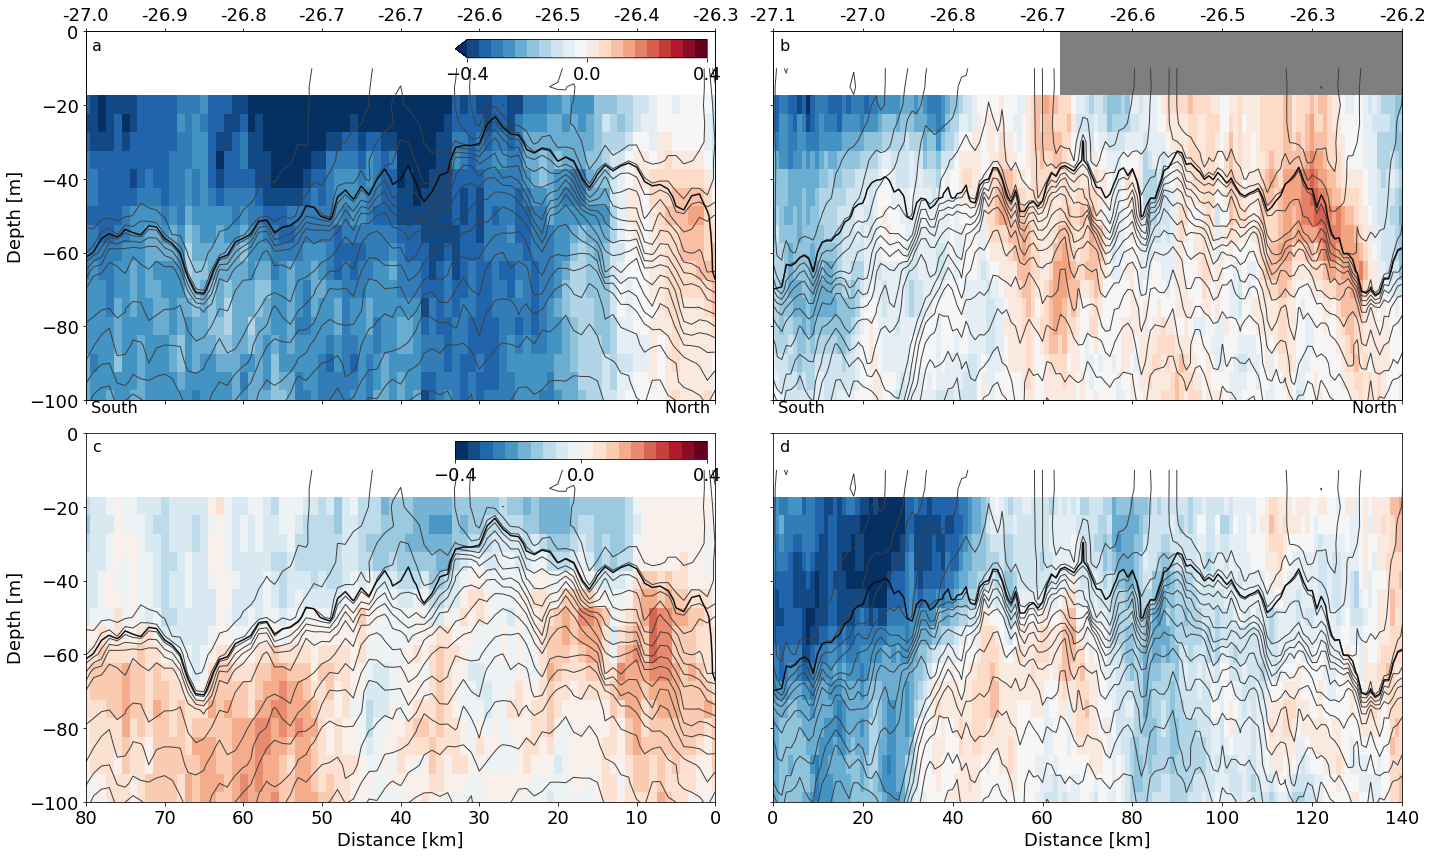

In [10]:
x_lim, y_lim = [80,0], [-100,0]
x_lim2 = [0,140]

if 'xy' in scan_sadcp_transects_1km_filament['ScanTransect1']:
    scan_sadcp_transects_1km_filament['ScanTransect1'] = (scan_sadcp_transects_1km_filament['ScanTransect1'].reset_index('xy').
                                                          swap_dims({'xy':'x_m'}))
if 'xy' in scan_sadcp_transects_1km_filament['ScanTransect2']:
    scan_sadcp_transects_1km_filament['ScanTransect2'] = (scan_sadcp_transects_1km_filament['ScanTransect2'].reset_index('xy').
                                                          swap_dims({'xy':'x_m'}))

si, nrows, ncols =  0, 2, 2
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,figsize = (ncols*10.,nrows*6))
axs = axs.ravel()
p1 = scan_sadcp_transects_1km_filament['ScanTransect1'].u.plot(x='x_km',ax=axs[si],vmin=U_range[0],vmax=U_range[1],
                                                                                  levels=21,cmap='RdBu_r',add_colorbar=False,
                                                                                 rasterized=True)
nice_plot(scan_sadcp_transects_1km_filament,'ScanTransect1', 0)
cbaxes = inset_axes(axs[si], width="40%", height="5%", loc=1) 
plt.colorbar(p1, cax=cbaxes, orientation='horizontal', ticks=np.linspace(U_range[0],U_range[1],3))
axs[si].set_ylim(y_lim)
axs[si].set_xlim(x_lim)
axs[si].set_xlabel('')
axs[si].set_xticklabels('')
axs[si].set_ylabel('Depth [m]')
# add north-south
axs[si].text(0,0,' South',transform=axs[si].transAxes,horizontalalignment='left',verticalalignment='top',fontsize=16)
axs[si].text(1,0,'North ',transform=axs[si].transAxes,horizontalalignment='right',verticalalignment='top',fontsize=16)
add_lats_on_top(scan_sadcp_transects_1km_filament['ScanTransect1'].swap_dims({'x_m': 'x_km'}),axs[si],dim='x_km')
    
si = si+1
p1 = scan_sadcp_transects_1km_filament['ScanTransect2'].u.plot(x='x_km',ax=axs[si],vmin=U_range[0],vmax=U_range[1],
                                                                                  levels=21,cmap='RdBu_r',add_colorbar=False,
                                                                                 rasterized=True)
nice_plot(scan_sadcp_transects_1km_filament,'ScanTransect2', si)
axs[si].set_ylim(y_lim)
axs[si].set_xlim(x_lim2)
axs[si].set_xlabel('')
axs[si].set_ylabel('')
axs[si].set_yticklabels('')
axs[si].set_xticklabels('')
# add night
x_night = scan_sadcp_transects_1km_filament['ScanTransect2'].swap_dims({'x_m':'time'}).sel(time=slice('2016-11-19T19:30','2016-11-20T06:00:00')).x_km.values
axs[si].axvspan(x_night[0],x_night[-1], facecolor='k', alpha=0.5,zorder=0)
# add north-south
axs[si].text(0,0,' South',transform=axs[si].transAxes,horizontalalignment='left',verticalalignment='top',fontsize=16)
axs[si].text(1,0,'North ',transform=axs[si].transAxes,horizontalalignment='right',verticalalignment='top',fontsize=16)
add_lats_on_top(scan_sadcp_transects_1km_filament['ScanTransect2'].swap_dims({'x_m': 'x_km'}),axs[si],dim='x_km')

si = si+1
p1 = scan_sadcp_transects_1km_filament['ScanTransect1'].v.plot(x='x_km',ax=axs[si],vmin=U_range[0],vmax=U_range[1],
                                                                                  levels=21,cmap='RdBu_r',add_colorbar=False,
                                                                                 rasterized=True)
nice_plot(scan_sadcp_transects_1km_filament,'ScanTransect1', si)
cbaxes = inset_axes(axs[si], width="40%", height="5%", loc=1) 
plt.colorbar(p1, cax=cbaxes, orientation='horizontal', ticks=np.linspace(U_range[0],U_range[1],3))
axs[si].set_ylim(y_lim)
axs[si].set_xlim(x_lim)
axs[si].set_xlabel('Distance [km]')
#axs[si].set_xticklabels('')
axs[si].set_ylabel('Depth [m]')

si = si+1
p1 = scan_sadcp_transects_1km_filament['ScanTransect2'].v.plot(x='x_km',ax=axs[si],vmin=U_range[0],vmax=U_range[1],
                                                                                  levels=21,cmap='RdBu_r',add_colorbar=False,
                                                                                 rasterized=True)
nice_plot(scan_sadcp_transects_1km_filament,'ScanTransect2', si)
axs[si].set_xlabel('Distance [km]')
axs[si].set_ylabel('')
axs[si].set_yticklabels('')
#axs[si].set_xticklabels('')
axs[si].set_ylim(y_lim)
axs[si].set_xlim(x_lim2)

# add letter labels - account for colorbars as axes
fg.label_axes(fig,labels=np.array(('a','b','c','d','','','','','','','','')),loc=(0.01,0.95),size=16)

plt.tight_layout() # squeeze subplots together

figname = figure_dir+'Figure_4_sections_filament_u_v_2transects.pdf'
fig.savefig(figname, dpi=300, transparent=True, bbox_inches='tight')

####    3. Rossby number analysis
##### 3a. Maps of Rossby number based on remote-sensing (SLA), ADCP (after kriging) and drifters

/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/xarray/plot/facetgrid.py:371: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


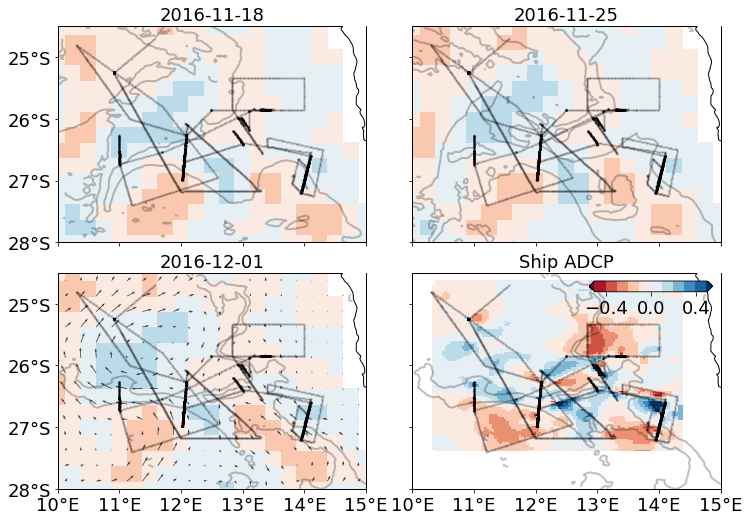

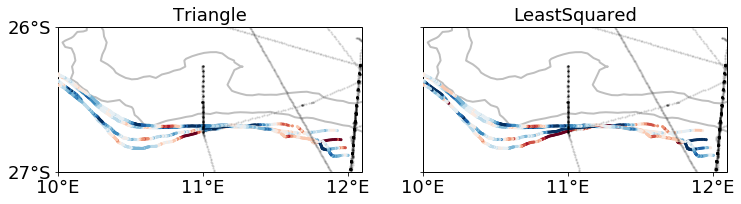

In [14]:
nrows, ncols =  1,2
projection = ccrs.PlateCarree()
x_y_lim = [10,16,-24.,-29]
x_y_lim = [10,15.,-24.5,-28.]

# ====== Ro from SSH data
si = 0
p = ((Ro_all)).plot(col='time', col_wrap=2, transform=projection,vmin=-0.5,vmax=0.5,levels=11,cmap='RdBu',
                figsize = (ncols*5.,nrows*7),add_colorbar=False, robust=True,
                subplot_kws={"projection": projection, 'aspect': 'auto'})

dataset = cfeature.NaturalEarthFeature(category='physical', name='land', scale='10m')
for axxs, ttime in zip(p.axes.flat,Ro_all.time):
    axxs.add_feature(dataset, zorder=100, edgecolor='k', facecolor = 'w')
    if ttime==Ro_all.time[2]:
        # add Geostrophic current vectors
        lon2, lat2 = np.meshgrid(gos_map.sel(time=sshtime,lon=slice(8,17),lat=slice(-30,-22)).lon.values,
                                 gos_map.sel(time=sshtime,lon=slice(8,17),lat=slice(-30,-22)).lat.values)
        gos_plt = axxs.quiver(lon2, lat2, gos_map.sel(time=sshtime,lon=slice(8,17),lat=slice(-30,-22)).ugos.values,
                            gos_map.sel(time=sshtime,lon=slice(8,17),lat=slice(-30,-22)).vgos.values , transform=projection,
                                alpha=0.75)#,scale=700)
    # show ship track
    (sadcp.sel(z=z_sel,method='nearest').sel(time=t_slice).plot.scatter(x='lon',y='lat',s=2,color='k',alpha=0.1,
                                                                        ax=axxs, transform=projection,zorder=100,
                                                                        vmin=-0.6,vmax=0.6, add_guide=False))
    axxs=setup_cartopy_ticks(axxs)
    # set axis limits
    axxs.set_extent(x_y_lim, projection)

    if ttime == Ro_all.time[-1]:
        # adding higher resolution Ro from ADCP
        Ro_krig.plot(x='lon_left',y='lat_left',transform=projection,vmin=-0.5,vmax=0.5,levels=11,cmap='RdBu',
                    ax=axxs,add_colorbar=False,robust=True)
        
        mappable = axxs.collections[0]
        cbaxes = inset_axes(axxs, width="40%", height="5%", loc=1) 
        plt.colorbar(mappable, cax=cbaxes, orientation='horizontal', ticks=np.linspace(-0.4,0.4,3))
        # add filament sst contour
        sst_map_ds.sst.sel(Date=Ro_all.time[-2].values,method='nearest').plot.contour(levels=np.array((17,18)), alpha=0.25,
                                                                              colors='k',ax=axxs, transform=projection)
        axxs.set_title('Ship ADCP')
    else:
        # add filament sst contour
        sst_map_ds.sst.sel(Date=ttime.values,method='nearest').plot.contour(levels=np.array((17,18)), alpha=0.25,
                                                                     colors='k',ax=axxs, transform=projection)
        axxs.set_title(ttime.dt.strftime("%Y-%m-%d").values)
    axxs.set_ylabel('')
    axxs.set_xlabel('')
    axxs.set_rasterized(True) # !! to reduce file size make this image, rest stays vectors
    axxs.set_aspect('equal', 'box')

figname = figure_dir+'Figure_5a_maps_Ro_from_SSH_SADCP_Drifters.pdf'
p.fig.savefig(figname, dpi=300, transparent=True, bbox_inches='tight')

# Drifters - rolling mean
x_y_lim = [10,12.1,-26,-27.]
#drifter_Ro
p=drifter_Ro_clean.rolling(time=24,center=True,min_periods=1).mean(skipna=True).plot.scatter(x='lon_res',y='lat_res',
                                                                                             hue='RossbyNumber',s=4,
                                                                                         col='calc_method', zorder=20,
                                                            transform=projection,vmin=-0.5,vmax=0.5,levels=11,cmap='RdBu',
                                                            figsize = (ncols*6.,nrows*6),add_guide=False, robust=True,
                                                            subplot_kws={"projection": projection, 'aspect': 'auto'})

dataset = cfeature.NaturalEarthFeature(category='physical', name='land', scale='10m')
cm = 0
for axxs in p.axes.flat:
    ttime = Ro_all.time[-2] # using last SST contours
    axxs.add_feature(dataset, zorder=100, edgecolor='k', facecolor = 'w')
    # show ship track
    (sadcp.sel(z=z_sel,method='nearest').sel(time=t_slice).plot.scatter(x='lon',y='lat',s=2,color='k',alpha=0.1,
                                                                        ax=axxs, transform=projection, zorder=100,
                                                                        vmin=-0.6,vmax=0.6, add_guide=False))
    axxs=setup_cartopy_ticks(axxs)
    # set axis limits
    axxs.set_extent(x_y_lim, projection)

    # add filament sst contour
    sst_map_ds.sst.sel(Date=ttime.values,method='nearest').plot.contour(levels=np.array((17,18)), alpha=0.25, zorder=0,
                                                                 colors='k',ax=axxs, transform=projection)
    axxs.set_title(drifter_Ro_clean.calc_method[cm].values)
    axxs.set_ylabel('')
    axxs.set_xlabel('')
    axxs.set_rasterized(True) # !! to reduce file size make this image, rest stays vectors
    axxs.set_aspect('equal', 'box')
    cm = cm+1
    
figname = figure_dir+'Figure_5b_maps_Ro_from_SSH_SADCP_Drifters.pdf'
p.fig.savefig(figname, dpi=300, transparent=True, bbox_inches='tight')

#####    3b. Ro across filaments

In [17]:
def calc_relative_vorticity(var_w_v_x_fo,u_var='across'):
    import gsw
    if u_var=='u':
        # need distance along lat only, to make it compatible with u
        if var_w_v_x_fo.lat[0]<var_w_v_x_fo.lat[-1]:
            # +/- 0.01 to avoid nan at ends
            new_lat = np.arange(var_w_v_x_fo.lat[0]+0.01,var_w_v_x_fo.lat[-1]-0.01,0.01)
        else:
            new_lat = np.arange(var_w_v_x_fo.lat[0]-0.01,var_w_v_x_fo.lat[-1]+0.01,-0.01)
        if 'xy' in var_w_v_x_fo:
            var_w_v_x_fo = var_w_v_x_fo.reset_index('xy').swap_dims({'xy':'x_m'})
        var_w_v_x_fo = var_w_v_x_fo.swap_dims({'x_m':'lat'})
        var_w_v_x_fo = var_w_v_x_fo.interp(lat=new_lat).swap_dims({'lat': 'x_m'})
        new_dx_m = gsw.distance(var_w_v_x_fo.lon.values,
                                var_w_v_x_fo.lat.values,p=0)
        dist = np.cumsum((np.append(np.array(0),new_dx_m)))
        var_w_v_x_fo = var_w_v_x_fo.assign_coords(x_m=dist)
        ## rebuild time
        #var_w_v_x_fo = var_w_v_x_fo.assign_coords(time=var_w_v_x_fo.time_secs.astype('datetime64'))

    var_w_v_x_fo, grid = ci.setup_dataset_grid(var_w_v_x_fo)
    # assuming m/s and m
    # recalculate for along-lat setup
    var_w_v_x_fo = ci.calc_N2_M2(var_w_v_x_fo, grid)
    # ci.calc_vertical_vorticity uses 'across' not 'u'
    var_w_v_x_fo['dv_dx'] = (grid.diff(var_w_v_x_fo[u_var],'X', boundary='fill',fill_value=np.nan)
                                /grid.diff(var_w_v_x_fo.x_m,'X', boundary='fill',fill_value=np.nan))
    var_w_v_x_fo['dv_dx'] = grid.interp(var_w_v_x_fo['dv_dx'],'X', boundary='fill',fill_value=np.nan) # realign
    var_w_v_x_fo['dv_dz'] = (grid.diff(var_w_v_x_fo[u_var],'Z', boundary='fill',fill_value=np.nan)
                                /grid.diff(var_w_v_x_fo.z,'Z', boundary='fill',fill_value=np.nan))
    var_w_v_x_fo['dv_dz'] = grid.interp(var_w_v_x_fo['dv_dz'],'Z', boundary='fill',fill_value=np.nan) # realign   
    # vertical vort = dv/dx - du/dy
    # estimate for now from dominant u-velocity / distance by latitude
    #du_dy = -dv_dx 
    var_w_v_x_fo['relative_vorticity'] =  - var_w_v_x_fo.dv_dx  # du_dy - dv_dx  
    # from Adams et al. 2017, Equation 15
    # dependent on cross-front and vertical gradients in alongfront velocity and buoyancy
    # here, our across-track velocity = along-front velocity and cross-front gradient = x or distance
    if 'db_dz' in var_w_v_x_fo and 'db_dx' in var_w_v_x_fo:
        var_w_v_x_fo['Ertel_Potential_Vorticity'] = ((var_w_v_x_fo.fo - var_w_v_x_fo.dv_dx)*var_w_v_x_fo.db_dz + 
                                                     var_w_v_x_fo.dv_dz*var_w_v_x_fo.db_dx)
    var_w_v_x_fo = ci.calc_Ri_Balanced(var_w_v_x_fo,grid)
    
    return var_w_v_x_fo
    
def calc_Ro_transect(trans_in,ladcp_ctd_trans=False):
    #if 'relative_vorticity' not in trans_in:
    trans_in = ci.calc_coriolis(trans_in)
    #if 'relative_vorticity' not in trans_in:
        #if ladcp_ctd_trans:
    trans_in = calc_relative_vorticity(trans_in,u_var='u')
        #else:
        #    trans_in = calc_relative_vorticity(trans_in,u_var='u')  
    trans_in['Ro'] = trans_in['relative_vorticity']/trans_in.fo
    return trans_in
        
def plot_Ro_transect(trans_in,ax,log_scale=True):
    if 'x_km' not in trans_in:
        trans_in = trans_in.assign_coords(x_km=trans_in.x_m/1e3 )
    if log_scale:
        pout = np.log(np.abs(trans_in['Ro'])).plot(x='x_km',vmin=-1,vmax=0,levels=6,ylim=(-100,0),ax=ax,
                                                             add_colorbar=False,rasterized=True,cmap='Blues')
    else:
        pout = trans_in['Ro'].plot(x='x_km',vmin=-1,vmax=1,levels=21,ylim=(-100,0),ax=ax,
                                   add_colorbar=False,rasterized=True,cmap='RdBu')
    return trans_in,pout


In [15]:
# calculate Ro for transects
# interpolates along lat, changing size, so create a new dataset to not overwrite
ladcp_ctd_transects_filament_LAT = OrderedDict()
scan_sadcp_transects_1km_filament_LAT = OrderedDict()
for key in scan_sadcp_transects_1km_filament:
    if key[0:5]=='LADCP':
        ladcp_ctd_transects_filament_LAT[key] = calc_Ro_transect(ladcp_ctd_transects_filament[key],
                                                                 ladcp_ctd_trans=True)
        scan_sadcp_transects_1km_filament_LAT[key] = scan_sadcp_transects_1km_filament[key] # mainly for keys to be consistent
    else:
        scan_sadcp_transects_1km_filament_LAT[key] = calc_Ro_transect(scan_sadcp_transects_1km_filament[key]
                                                                      ,ladcp_ctd_trans=False)


/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:605: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:608: RuntimeWarning: invalid value encountered in add
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:605: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:608: RuntimeWarning: invalid value encountered in add
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:605: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x

##### Plotting sections across the filament: Rossby and Richardson number, and Erterl Potential Vorticity

/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/ipykernel_launcher.py:119: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


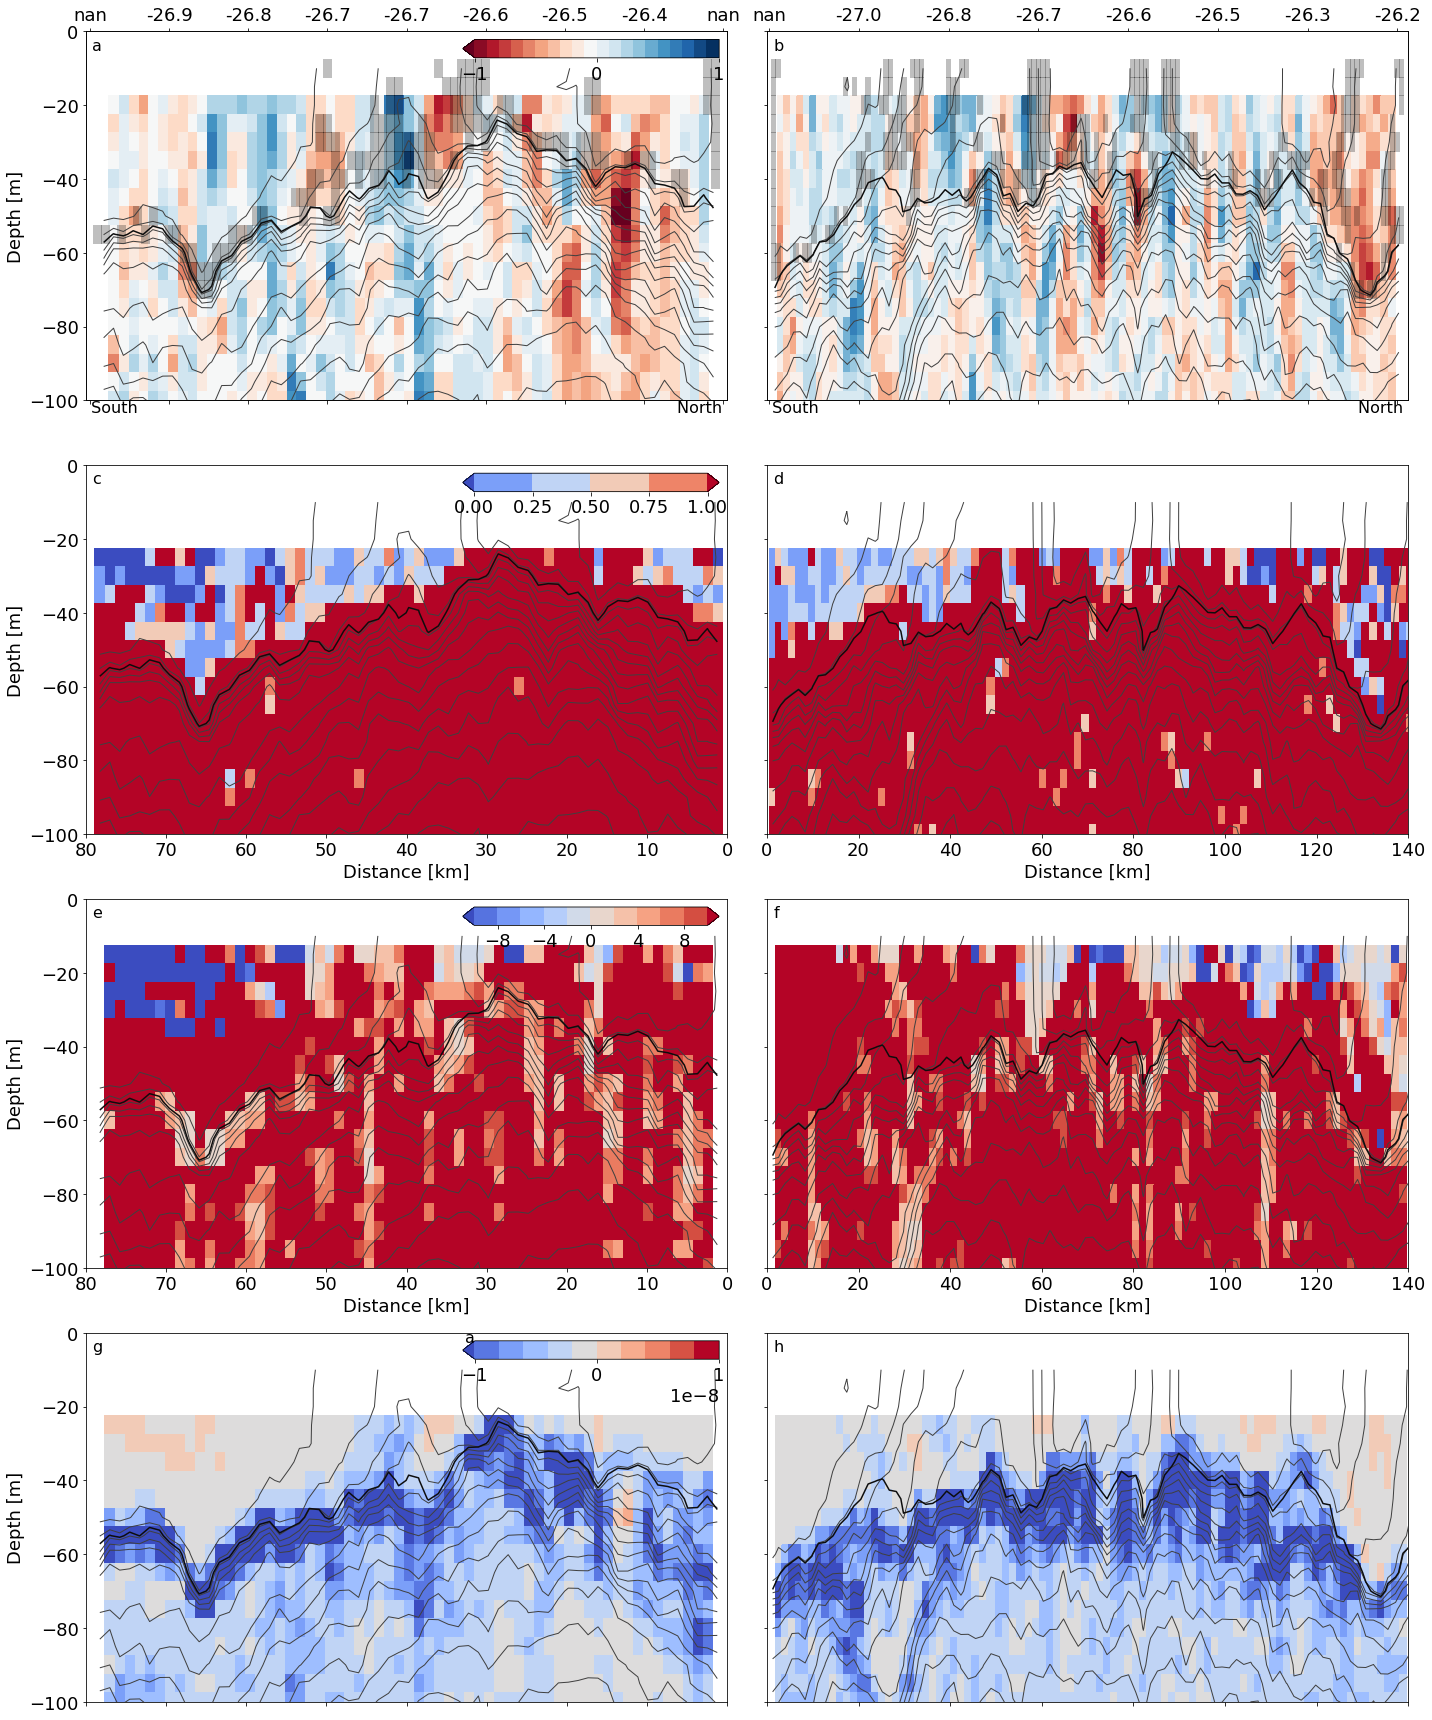

In [27]:
x_lim, y_lim = [80,0], [-100,0]
x_lim2 = [0,140]

si, nrows, ncols =  0, 4, 2
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,figsize = (ncols*10.,nrows*6))
axs = axs.ravel()
si = 0

for key in scan_sadcp_transects_1km_filament_LAT:
    if key[0:5]=='LADCP':
        continue
    else:
        trans_in,p1 = plot_Ro_transect(scan_sadcp_transects_1km_filament_LAT[key],axs[si],log_scale=False)
        scan_sadcp_transects_1km_filament_LAT = nice_plot(scan_sadcp_transects_1km_filament_LAT,key, si)
        # add horizontal gradient as shading
        h_grad=np.abs(scan_sadcp_transects_1km_filament[key].db_dx.
                where(scan_sadcp_transects_1km_filament[key].MLD<mld_level))
        h_grad.where(h_grad>1e-7).plot(x='x_km',ax=axs[si],alpha=0.25,colors='k',levels=[1e-9,2e-9],add_colorbar=False)

    if si == 0:
        cbaxes = inset_axes(axs[si], width="40%", height="5%", loc=1) 
        plt.colorbar(p1, cax=cbaxes, orientation='horizontal', ticks=np.linspace(-1,1,3))
    axs[si].set_ylim(y_lim)
    axs[si].set_xlabel('')
    axs[si].set_xticklabels('')
    if si % 2: # even
        axs[si].set_ylabel('')
        axs[si].set_yticklabels('')
    else:
        axs[si].set_ylabel('Depth [m]')
    # add north-south
    axs[si].text(0,0,' South',transform=axs[si].transAxes,horizontalalignment='left',verticalalignment='top',fontsize=16)
    axs[si].text(1,0,'North ',transform=axs[si].transAxes,horizontalalignment='right',verticalalignment='top',fontsize=16)
    ax2 = add_lats_on_top(trans_in.swap_dims({'x_m': 'x_km'}),axs[si],dim='x_km')

    if scan_sadcp_transects_1km_filament_LAT[key].TransectDirection == 'N-S':
        axs[si].set_xlim(axs[si].get_xlim()[1],axs[si].get_xlim()[0])
        ax2.set_xlim(ax2.get_xlim()[1],ax2.get_xlim()[0])
    si = si+1    
    
### ==== Ri_G
p1 = scan_sadcp_transects_1km_filament_LAT['ScanTransect1'].Rig.plot(x='x_km',ax=axs[si],vmin=0,vmax=1,
                                                                                       levels=5,cmap='coolwarm',add_colorbar=False,
                                                                                 rasterized=True)
nice_plot(scan_sadcp_transects_1km_filament_LAT,'ScanTransect1', si)
cbaxes = inset_axes(axs[si], width="40%", height="5%", loc=1) 
plt.colorbar(p1, cax=cbaxes, orientation='horizontal', ticks=np.linspace(0,1,5))
axs[si].set_ylim(y_lim)
axs[si].set_xlim(x_lim)
axs[si].set_xlabel('Distance [km]')
axs[si].set_ylabel('Depth [m]')

si = si+1
p1 = scan_sadcp_transects_1km_filament_LAT['ScanTransect2'].Rig.plot(x='x_km',ax=axs[si],vmin=0,vmax=1,
                                                                                       levels=5,cmap='coolwarm',add_colorbar=False,
                                                                                 rasterized=True)
nice_plot(scan_sadcp_transects_1km_filament_LAT,'ScanTransect2', si)
axs[si].set_xlabel('Distance [km]')
axs[si].set_ylabel('')
axs[si].set_yticklabels('')
axs[si].set_ylim(y_lim)
axs[si].set_xlim(x_lim2)

### ==== Ri_B
si = si+1 
p1 = scan_sadcp_transects_1km_filament_LAT['ScanTransect1'].Rib.plot(x='x_km',ax=axs[si],vmin=-10,vmax=10,levels=11,
                                                                                       cmap='coolwarm',add_colorbar=False,
                                                                                 rasterized=True)
nice_plot(scan_sadcp_transects_1km_filament_LAT,'ScanTransect1', si)
cbaxes = inset_axes(axs[si], width="40%", height="5%", loc=1) 
plt.colorbar(p1, cax=cbaxes, orientation='horizontal')#, ticks=np.linspace(0,50,5))
axs[si].set_ylim(y_lim)
axs[si].set_xlim(x_lim)
axs[si].set_xlabel('Distance [km]')
axs[si].set_ylabel('Depth [m]')

si = si+1
p1 = scan_sadcp_transects_1km_filament_LAT['ScanTransect2'].Rib.plot(x='x_km',ax=axs[si],vmin=-10,vmax=10,levels=11,
                                                                                      cmap='coolwarm',add_colorbar=False,
                                                                                 rasterized=True)
nice_plot(scan_sadcp_transects_1km_filament_LAT,'ScanTransect2', si)
axs[si].set_xlabel('Distance [km]')
axs[si].set_ylabel('')
axs[si].set_yticklabels('')
axs[si].set_ylim(y_lim)
axs[si].set_xlim(x_lim2)

### ==== EPV
si = si+1 
p1 = scan_sadcp_transects_1km_filament_LAT['ScanTransect1'].Ertel_Potential_Vorticity.plot(x='x_km',ax=axs[si],vmin=-1e-8,vmax=1e-8,
                                                                                       levels=11,cmap='coolwarm',add_colorbar=False,
                                                                                 rasterized=True)
nice_plot(scan_sadcp_transects_1km_filament_LAT,'ScanTransect1', si)
cbaxes = inset_axes(axs[si], width="40%", height="5%", loc=1) 
plt.colorbar(p1, cax=cbaxes, orientation='horizontal', ticks=np.linspace(-1e-8,1e-8,3))
axs[si].set_ylim(y_lim)
axs[si].set_xlim(x_lim)
axs[si].set_xlabel('')
axs[si].set_xticklabels('')
axs[si].set_ylabel('Depth [m]')

si = si+1
p1 = scan_sadcp_transects_1km_filament_LAT['ScanTransect2'].Ertel_Potential_Vorticity.plot(x='x_km',ax=axs[si],vmin=-1e-8,vmax=1e-8,
                                                                                       levels=11,cmap='coolwarm',add_colorbar=False,
                                                                                 rasterized=True)
nice_plot(scan_sadcp_transects_1km_filament_LAT,'ScanTransect2', si)
axs[si].set_xlabel('')
axs[si].set_ylabel('')
axs[si].set_yticklabels('')
axs[si].set_xticklabels('')
axs[si].set_ylim(y_lim)
axs[si].set_xlim(x_lim2)

# add letter labels - account for colorbars as axes
fg.label_axes(fig,labels=np.array(('a','b','c','d','e','f','g','h','','','','','')),loc=(0.01,0.95),size=16)

plt.tight_layout() # squeeze subplots together

figname = figure_dir+'Figure_6_sections_filament_Ro_EPV_Ri.pdf'
fig.savefig(figname, dpi=300, transparent=True, bbox_inches='tight')

##### More sections of Rossby number at different locations along the filament

/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:605: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:608: RuntimeWarning: invalid value encountered in add
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:605: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough 

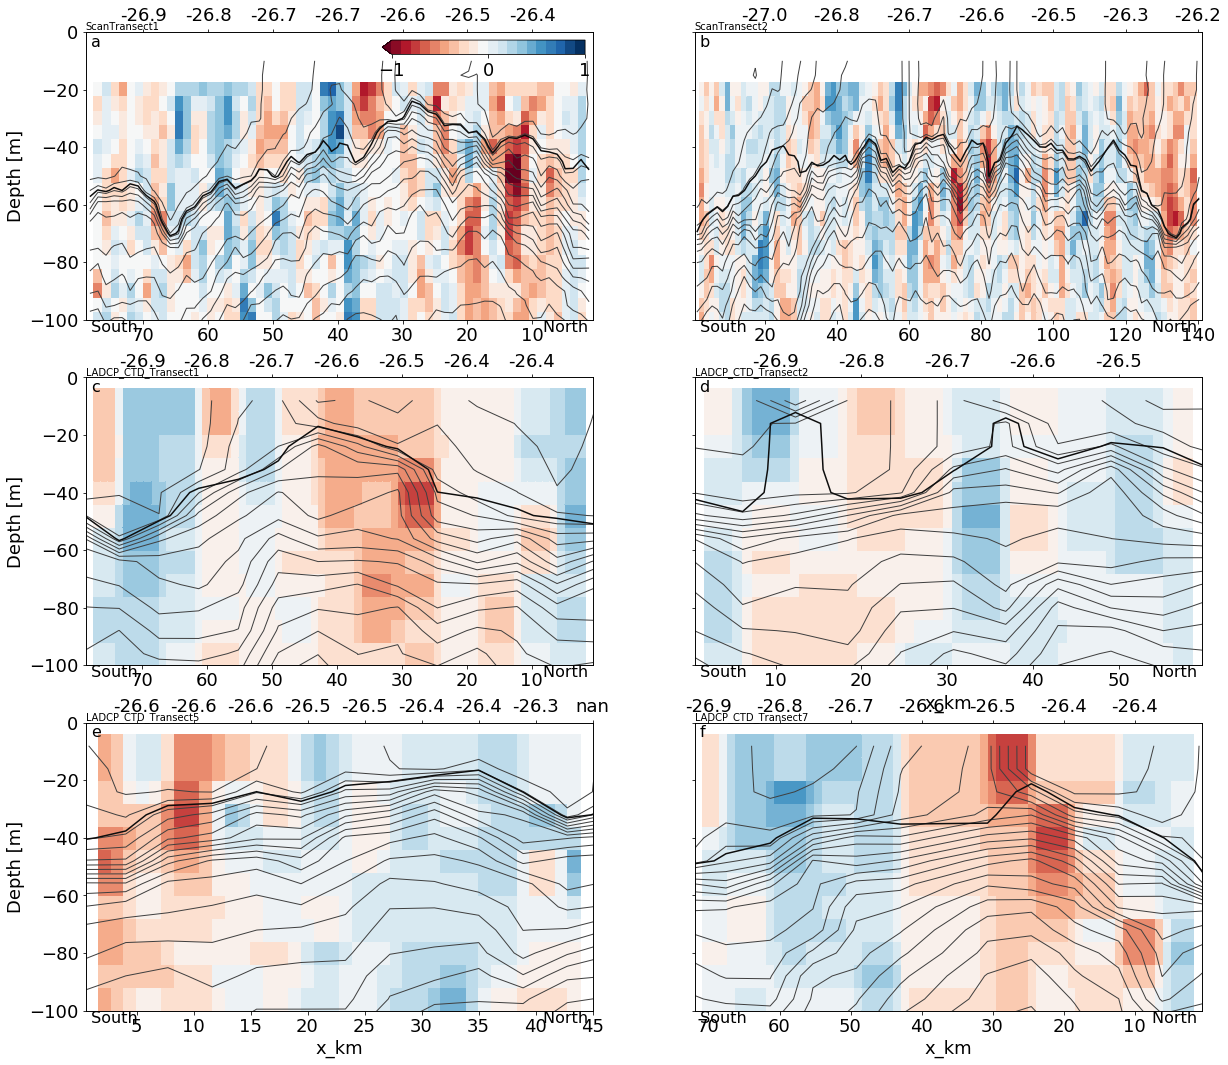

In [15]:
# matching scale Ro, all transects, and with sadcp or ladcp

x_lim, y_lim = [80,0], [-100,0]
x_lim2 = [0,140]

si, nrows, ncols =  0, 3, 2
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,figsize = (ncols*10.,nrows*6))
axs = axs.ravel()
si = 0

for key in scan_sadcp_transects_1km_filament_LAT:
    if key[0:5]=='LADCP':
        trans_in,p1 = plot_Ro_transect(ladcp_ctd_transects_filament_LAT[key],axs[si],
                                       log_scale=False)
        #ladcp_ctd_transects_filament[key] = ladcp_ctd_transects_filament[key].reset_index('xy').swap_dims({'xy': 'x_km'})
        nice_plot(ladcp_ctd_transects_filament,key, si)
    else:
        trans_in,p1 = plot_Ro_transect(scan_sadcp_transects_1km_filament_LAT[key],axs[si],log_scale=False)
        nice_plot(scan_sadcp_transects_1km_filament_LAT,key, si)

    plt.text(0,1,(scan_sadcp_transects_1km_filament_LAT[key].TransectName),
                  transform=axs[si].transAxes,horizontalalignment='left',verticalalignment='bottom')        

    #nice_plot(scan_sadcp_transects_1km_filament_LAT,key, si)
    if si == 0:
        cbaxes = inset_axes(axs[si], width="40%", height="5%", loc=1) 
        plt.colorbar(p1, cax=cbaxes, orientation='horizontal', ticks=np.linspace(-1,1,3))
    axs[si].set_ylim(y_lim)
    if si < (nrows*ncols-3):
        axs[si].set_xlabel('')
    if si % 2: # even
        axs[si].set_ylabel('')
        axs[si].set_yticklabels('')
    else:
        axs[si].set_ylabel('Depth [m]')
    # add north-south
    axs[si].text(0,0,' South',transform=axs[si].transAxes,horizontalalignment='left',verticalalignment='top',fontsize=16)
    axs[si].text(1,0,'North ',transform=axs[si].transAxes,horizontalalignment='right',verticalalignment='top',fontsize=16)
    ax2 = add_lats_on_top(trans_in.swap_dims({'x_m': 'x_km'}),axs[si],dim='x_km')

    if scan_sadcp_transects_1km_filament_LAT[key].TransectDirection == 'N-S':
        axs[si].set_xlim(axs[si].get_xlim()[1],axs[si].get_xlim()[0])
        ax2.set_xlim(ax2.get_xlim()[1],ax2.get_xlim()[0])


    si = si+1    
plt.tight_layout() # squeeze subplots together

# add letter labels - account for colorbars as axes
fg.label_axes(fig,labels=np.array(('a','b','c','d','e','f','','','','','','','')),loc=(0.01,0.95),size=16)

plt.tight_layout() # squeeze subplots together

figname = figure_dir+'Figure_S7_sections_filament_Ro_all_transects.pdf'
fig.savefig(figname, dpi=300, transparent=True, bbox_inches='tight')

#### 4. Wavelet analysis identifying correlation of wind and drifter movements

/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/pycwt/wavelet.py:594: RuntimeWarning: invalid value encountered in arctanh
  aa = np.round(np.arctanh(np.array([al1, al2]) * 4))


NOTE: WCT significance loaded from cache.



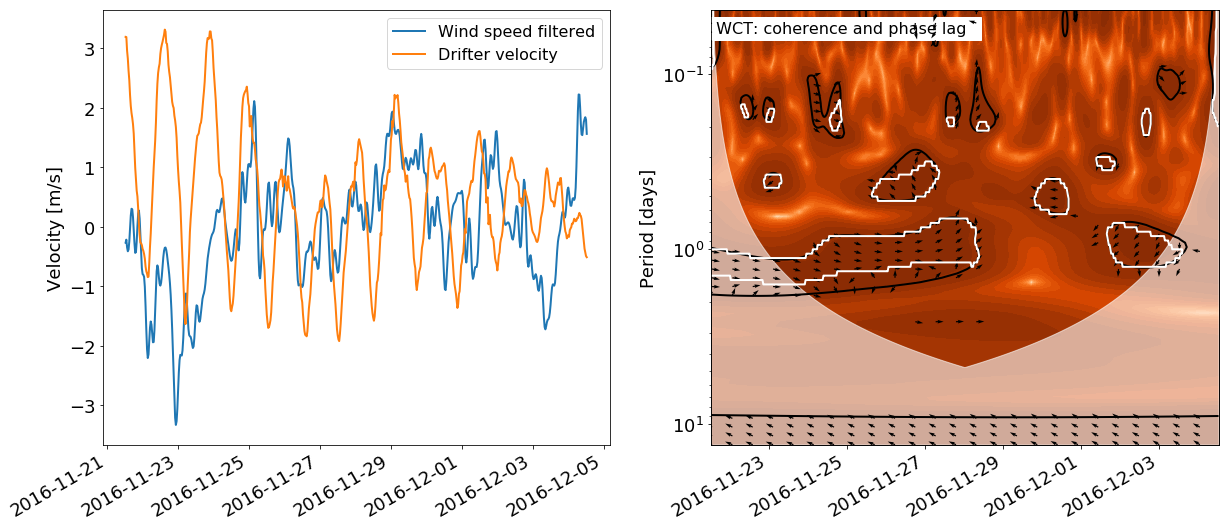

In [8]:
# wavelet comparison of cv, vinst and windspeed from ship
wind_dship =xr.open_dataset('Benguela/netcdf_files/wind_from_dship.nc')

ndays = 13
drifter_slice = slice(0,12)
t1_str = '2016-11-21T12:30:00'
sel_time = slice(drifter_ds.sel(time=t1_str,method='nearest').time.values,
                 drifter_ds.sel(time=t1_str,method='nearest').time.values  + np.timedelta64(ndays, 'D') )

cv_ts = (drifter_ds.sel(time=sel_time).isel(drifter=drifter_slice).ellipse_velocity.sel(velocity_type=['cv','cvres','vins']).
               drop(['x_m','z']).squeeze().mean('drifter'))
wind_ts = (wind_dship.interp_like(drifter_ds).WindSpeed).sel(time=slice(cv_ts.time[0],cv_ts.time[-1]))

cv_ts = xr.merge((cv_ts,xr.Dataset({"wind": wind_ts}))).map(standardize)

cv_ts = cv_ts.sel(time=slice(max(cv_ts.ellipse_velocity.sel(velocity_type='cv').dropna('time',how='all').time[0].values,
                                 wind_dship.time[0].values),
                             min(cv_ts.ellipse_velocity.sel(velocity_type='cv').dropna('time',how='all').time[-1].values,
                                 wind_dship.time[-1].values)))

dt = cv_ts.time.diff('time').mean().values
if type(dt)==np.timedelta64:
    dt = dt.astype('float64')/(1e9*60*60*24) # ns to days

def ssa_filter_local(dat,window=150,pc_s=None):
    if dat.size < 300:
        window = 25
    if not isinstance(pc_s, np.ndarray):
        print('SSA')
        pc_s =  np.arange(1,window)
    pc_out, _, v_out = ssa.ssa(dat.values, window)
    ssa_out = ssa.inv_ssa(pc_out, v_out, pc_s)
    return ssa_out

cv_ts['wind_ssa'] = xr.full_like(cv_ts.wind,ssa_filter_local(cv_ts.wind.fillna(0),window=50, pc_s=np.arange(0,15)))
cv_ts['wind_ssa'] = cv_ts['wind_ssa'].where(~np.isnan(cv_ts.wind.values))

nrows, ncols =  1,2
fig = plt.figure(figsize=(ncols*10.,nrows*8)) ## setting over-all figure size 

axs = [None]*nrows*ncols

si = 0
axs[si] = plt.subplot(nrows, ncols, si+1)
cv_ts.wind_ssa.plot.line(x='time', label='Wind speed filtered')

# =======
cv_ts.ellipse_velocity.sel(velocity_type='cv').plot.line(x='time',label='Drifter velocity',ax=axs[0])

si = si+1
axs[si] = plt.subplot(nrows, ncols, si+1)

xwt_ds, wct_ds = sw.run_cross_coherence_wavelet((cv_ts.wind_ssa.dropna('time',how='all').squeeze().values),
                                                (cv_ts.ellipse_velocity.sel(velocity_type='cv').dropna('time',how='all').squeeze().values),
                                                cv_ts.time.dropna('time',how='all').squeeze().values,
                                                dt,wct_cache=True)
wto = sw.wto_calc(wct_ds,xwt_ds,strict=2)

sw.waveplt_WavePower(wct_ds,axs[si],power_name='WCT')
wto.plot.contour(levels=[0.5, 1.0],colors='w',yincrease=False)
axs[si].text(0,0.975,' WCT: coherence and phase lag  ',horizontalalignment='left',verticalalignment='top',transform=axs[si].transAxes,
            fontsize=16,backgroundcolor='w')     
axs[si].set_ylabel('')

# =======
axs[0].legend()
axs[0].set_ylabel('Velocity [m/s]')
axs[0].set_xlabel('')
axs[0].set_title('')
axs[1].set_xlabel('')
axs[1].set_ylabel('Period [days]')

figname = figure_dir+'Figure_7_drifter_analysis_release1_vs_Wind.pdf'
fig.savefig(figname, dpi=300, transparent=True, bbox_inches='tight')